Este programa corre un modelo ARIMA sobre la serie de supermercados a precios corrientes.
https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
https://www.justintodata.com/arima-models-in-python-time-series-prediction/
http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/
https://people.duke.edu/~rnau/411fcst.htm
https://otexts.com/fpp2/seasonal-arima.html

In [1]:
import pandas as pd
from pandas import read_csv
from datetime import datetime
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot
from pandas import DataFrame
from statsmodels.tsa.arima.model import ARIMA


Cargo la serie y defino la columna de fechas

In [2]:
series = read_csv('serieScorr.csv', encoding= 'unicode_escape', delimiter=',') 
series['indice_tiempo'] = pd.to_datetime(series['indice_tiempo'])
ventas=series['ventas_precios_corrientes']

Grafico

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325 entries, 0 to 324
Data columns (total 2 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   indice_tiempo              325 non-null    datetime64[ns]
 1   ventas_precios_corrientes  325 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.2 KB


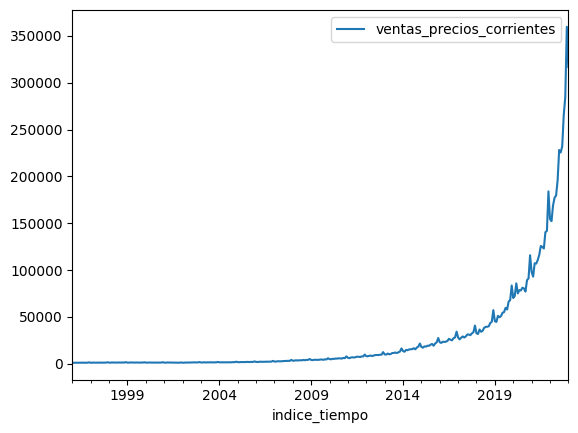

In [3]:
series.set_index('indice_tiempo').plot()
series.info()


Observo que la variancia no es constante a traves del tiempo, por lo que aplico logaritmo.
RECORDAR APLICAR FUNCION INVERSA A LA HORA DE OBTENER PRONOSTICOS.

<AxesSubplot: >

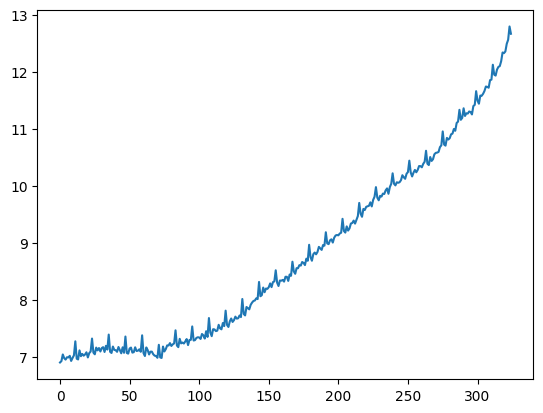

In [3]:
import numpy as np
ventas = np.log(ventas) # don't forget to transform the data back when making real predictions
ventas.plot()


Claramente la serie no es estacionaria (no mantiene la media a lo largo del tiempo), por lo que deberemos diferenciar. The ACF plot shows the correlations with the lags are high and positive with very slow decay. While the PACF plot shows the partial autocorrelations have a single spike at lag 1. These are both signs of a trended time series. So our time series is not stationary.

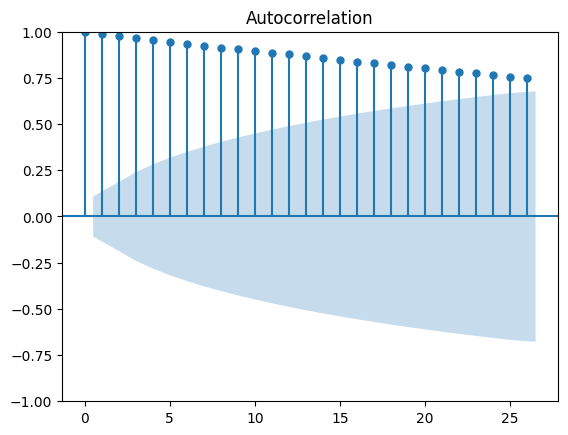

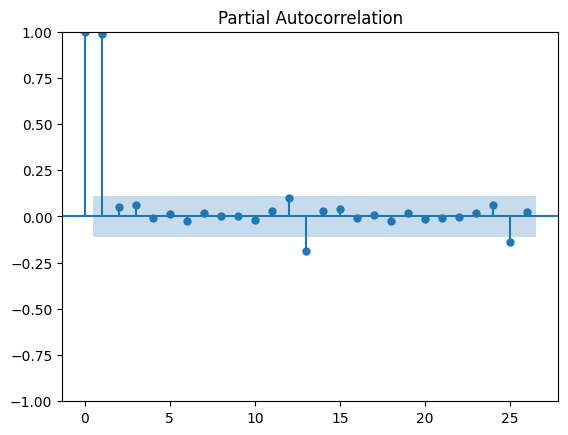

In [5]:

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_original = plot_acf(ventas)
pacf_original = plot_pacf(ventas)


Testeo estacionariedad con Augmented Dicker Fuller Test

In [6]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(ventas)
print(f'p-value: {adf_test[1]}')

p-value: 0.9990656191762264


<AxesSubplot: >

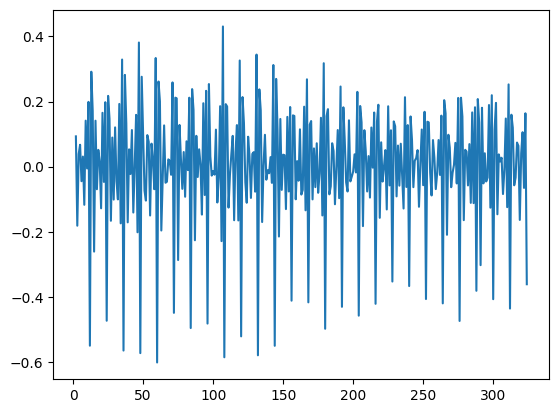

In [16]:
ventas_diff = ventas.diff().dropna()
ventas_diff2= ventas_diff.diff().dropna()
ventas_diff2.plot()


Testeo estacionariedad con Augmented Dicker Fuller Test de la serie diferenciada y veo que todavia no pasa
el testeo de Estacion.

In [8]:
adf_test = adfuller(ventas_diff)
print(f'p-value: {adf_test[1]}')

p-value: 0.9257355279169419


Diferencio 2 veces y veo que esta vez si el p valor es menor a 0.05.

In [17]:
adf_test = adfuller(ventas_diff2)
print(f'p-value: {adf_test[1]}')

p-value: 2.248622302870463e-14


Sigamos entonces analizando para ver qué valores vamos a tomar para hacer el grid search de arima

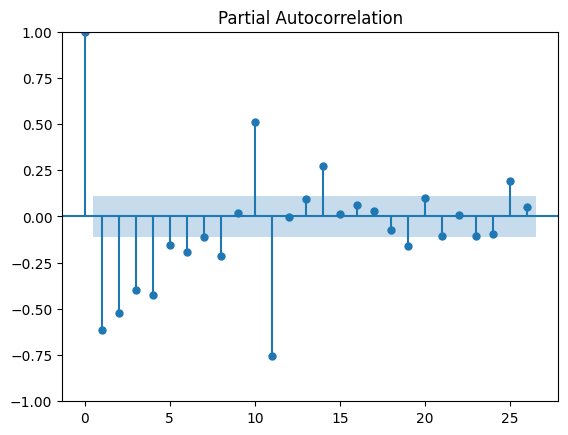

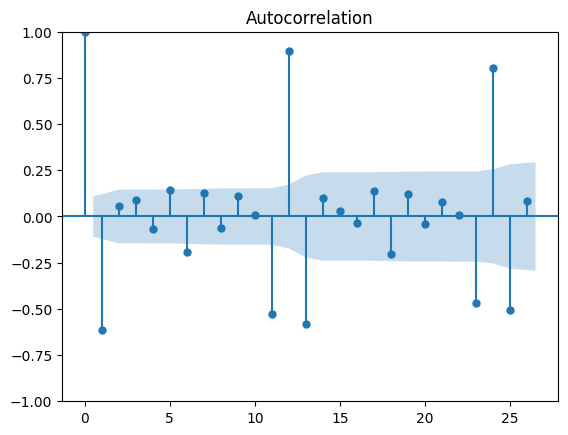

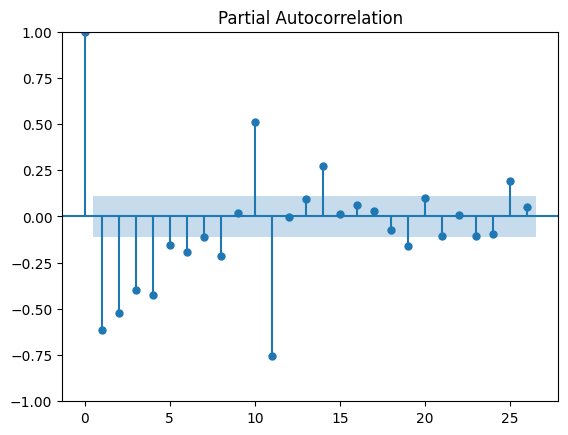

In [19]:
plot_acf(ventas_diff2)
plot_pacf(ventas_diff2)

In [20]:
import pmdarima as pm
auto_arima = pm.auto_arima(ventas,stepwise=True,seasonal=True, m=12)
auto_arima

ARIMA(order=(2, 2, 2), scoring_args={}, seasonal_order=(2, 0, 2, 12),
      suppress_warnings=True, with_intercept=False)

In [15]:
print(auto_arima.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  325
Model:             SARIMAX(2, 2, 2)x(2, 0, 2, 12)   Log Likelihood                 629.802
Date:                            Fri, 30 Jun 2023   AIC                          -1241.605
Time:                                    13:50:13   BIC                          -1207.606
Sample:                                         0   HQIC                         -1228.033
                                            - 325                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0123      0.111     -9.123      0.000      -1.230      -0.795
ar.L2         -0.5549      0.063   

The residuals look random in general, and their density looks normally distributed with a mean of around 0.

c:\Users\dolor\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\dolor\miniconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                    SARIMAX Results                                     
Dep. Variable:        ventas_precios_corrientes   No. Observations:                  325
Model:             ARIMA(2, 2, 2)x(2, 0, 2, 12)   Log Likelihood                 629.802
Date:                          Sat, 01 Jul 2023   AIC                          -1241.605
Time:                                  09:43:44   BIC                          -1207.606
Sample:                                       0   HQIC                         -1228.033
                                          - 325                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0123      0.111     -9.123      0.000      -1.230      -0.795
ar.L2         -0.5549      0.063     -8.819      0.

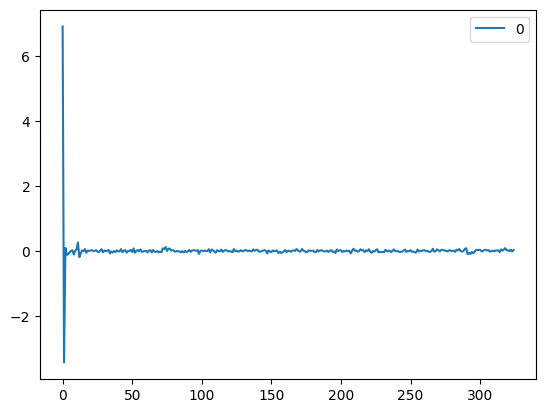

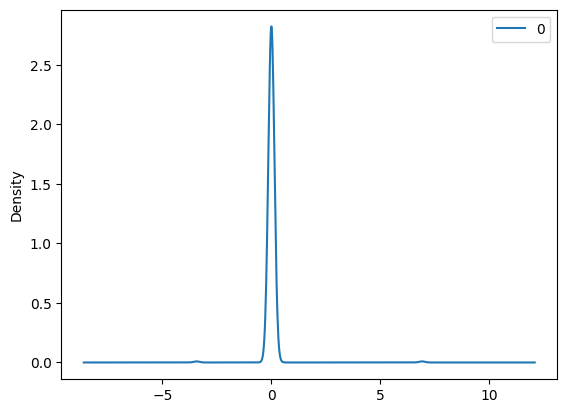

                0
count  325.000000
mean     0.011901
std      0.429983
min     -3.429576
25%     -0.018171
50%      0.000040
75%      0.022717
max      6.906525


In [32]:
# fit model
model = ARIMA(ventas, order=(2,2,2), seasonal_order=(2,0,2,12))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

The lower lags barely show any significant ‘spikes’.
These show that the residuals are close to white noise. We are ready to forecast with this model ARIMA(2, 1, 0).

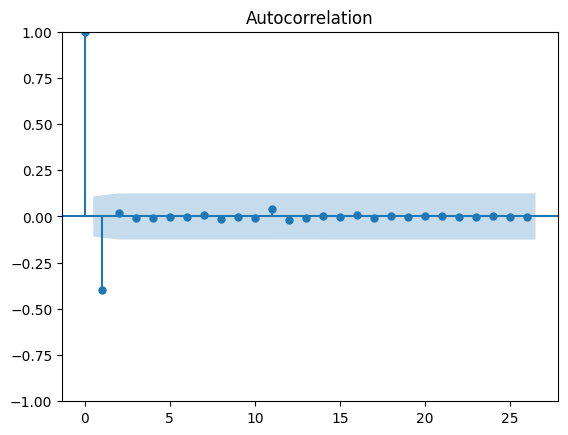

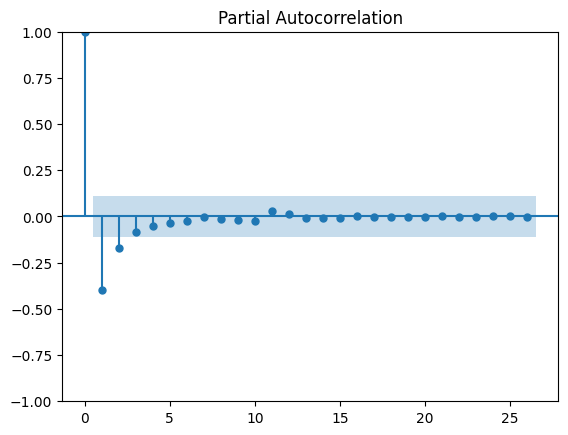

In [33]:
acf_res = plot_acf(residuals)
pacf_res = plot_pacf(residuals)

*********GRIDSEARCH********

Establezco los valores para evaluar. Uso lo obtenido en los resultados anteriores

In [4]:
# grid search ARIMA parameters for time series
import warnings
from math import sqrt
from pandas import read_csv
#from pandas import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order, sarima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order, seasonal_order=sarima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	rmse = sqrt(mean_squared_error(test, predictions))
	return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values,P_values, D_values, Q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg, best_scfg = float("inf"), None, None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				for P in P_values:
					for D in D_values:
						for Q in Q_values:
							order = (p,d,q)
							Sorder=(P,D,Q,12)
							try:
								rmse = evaluate_arima_model(dataset, order, Sorder)
								if rmse < best_score:
									best_score, best_cfg, best_scfg = rmse, order, Sorder
								print('ARIMA%s %s RMSE=%.3f' % (order,Sorder,rmse))
							except:
								continue
	print('Best ARIMA%s %s RMSE=%.3f' % (best_cfg, best_scfg, best_score))

# evaluate parameters
p_values = [0, 1, 2]
P_values= [0, 1, 2]
d_values = [1, 2]
D_values= [0, 1]
q_values = [0, 1, 2]
Q_values= [0, 1, 2]
warnings.filterwarnings("ignore")
evaluate_models(ventas.values, p_values, d_values, q_values,P_values, D_values, Q_values)

ARIMA(0, 1, 0) (0, 0, 0, 12) RMSE=0.107
ARIMA(0, 1, 0) (0, 0, 1, 12) RMSE=0.070
ARIMA(0, 1, 0) (0, 0, 2, 12) RMSE=0.057
ARIMA(0, 1, 0) (0, 1, 0, 12) RMSE=0.042
ARIMA(0, 1, 0) (0, 1, 1, 12) RMSE=0.039
ARIMA(0, 1, 0) (0, 1, 2, 12) RMSE=0.038
ARIMA(0, 1, 0) (1, 0, 0, 12) RMSE=0.041
ARIMA(0, 1, 0) (1, 0, 1, 12) RMSE=0.040
ARIMA(0, 1, 0) (1, 0, 2, 12) RMSE=0.038
ARIMA(0, 1, 0) (1, 1, 0, 12) RMSE=0.041
ARIMA(0, 1, 0) (1, 1, 1, 12) RMSE=0.038
ARIMA(0, 1, 0) (1, 1, 2, 12) RMSE=0.038
ARIMA(0, 1, 0) (2, 0, 0, 12) RMSE=0.040
ARIMA(0, 1, 0) (2, 0, 1, 12) RMSE=0.038
ARIMA(0, 1, 0) (2, 0, 2, 12) RMSE=0.038
ARIMA(0, 1, 0) (2, 1, 0, 12) RMSE=0.041
ARIMA(0, 1, 0) (2, 1, 1, 12) RMSE=0.038
ARIMA(0, 1, 0) (2, 1, 2, 12) RMSE=0.036
ARIMA(0, 1, 1) (0, 0, 0, 12) RMSE=0.111
ARIMA(0, 1, 1) (0, 0, 1, 12) RMSE=0.072
ARIMA(0, 1, 1) (0, 0, 2, 12) RMSE=0.059
ARIMA(0, 1, 1) (0, 1, 0, 12) RMSE=0.040
ARIMA(0, 1, 1) (0, 1, 1, 12) RMSE=0.039
ARIMA(0, 1, 1) (0, 1, 2, 12) RMSE=0.037
ARIMA(0, 1, 1) (1, 0, 0, 12) RMSE=0.040


Veo los residuos del modelo elegido Best ARIMA(2, 2, 2) (2, 1, 2, 12) RMSE=0.033

                                    SARIMAX Results                                     
Dep. Variable:        ventas_precios_corrientes   No. Observations:                  325
Model:             ARIMA(2, 2, 2)x(2, 1, 2, 12)   Log Likelihood                 634.893
Date:                          Thu, 06 Jul 2023   AIC                          -1251.786
Time:                                  08:57:31   BIC                          -1218.128
Sample:                                       0   HQIC                         -1238.333
                                          - 325                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8417      0.170     -4.942      0.000      -1.176      -0.508
ar.L2         -0.4185      0.082     -5.132      0.

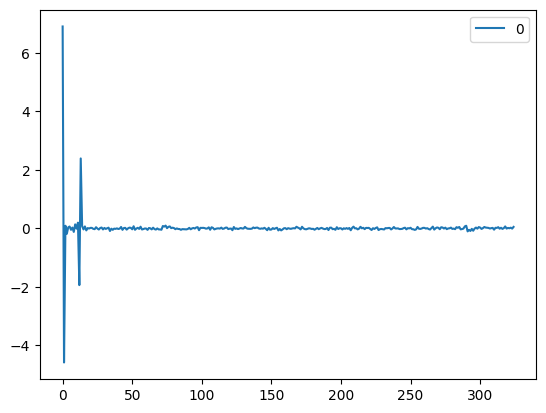

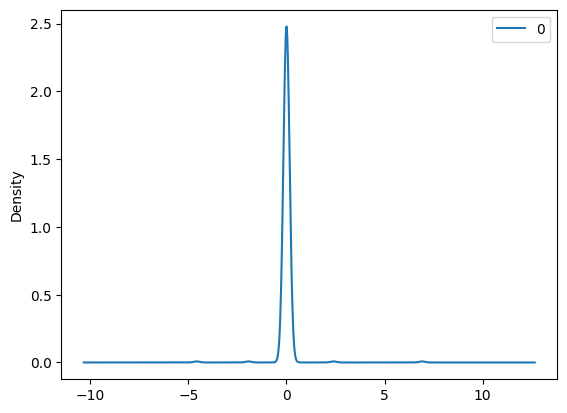

                0
count  325.000000
mean     0.011049
std      0.492407
min     -4.580663
25%     -0.019082
50%      0.001965
75%      0.022059
max      6.906525


In [5]:
# fit model
model = ARIMA(ventas, order=(2,2,2), seasonal_order=(2,1,2,12))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

Una vez elegido el modelo efectuamos las predicciones. Recordemos que debemos hacer exp ya que para 
estabilizar varianzas aplicamos ln al inicio.

In [9]:
model = ARIMA(ventas, order=(2,2,2), seasonal_order=(2,1,2,12))
model_fit = model.fit()


In [14]:
yhat = model_fit.forecast(1)
print(yhat)


325    12.653682
dtype: float64


In [16]:
import math
yhatf=math.exp(yhat)
print(yhatf)

312913.47294811014


Las ventas estimadas para febrero de 2023 según este método dan 312.913,47 millones de pesos